# Data Generation for Hybrid CNN

### Workflow:

Get 4 files + other info:

- drone image
- planetscope image
- 0 shapefile
- 1 shapefile
- upload location

After getting files:

1. Clip image for satellite for each class
2. Tileize each satellite image
3. remove zero tiles


4. Generate tiles based on each tiled satellite image
5. remove additional tiles



In [1]:
%%capture
!apt-get update
!apt-get install libgdal-dev -y
!apt-get install python-gdal -y
!apt-get install python-numpy python-scipy -y
!pip install rasterio
!pip install fiona
!pip install geopandas
!pip install PyCRS
!pip install -i https://test.pypi.org/simple/ gis-utils-pkg-dillhicks==0.0.3

In [2]:
import rasterio
from shapely.geometry import box
import geopandas as gpd
from rasterio.mask import mask
from rasterio.plot import show
from tqdm.autonotebook import tqdm
import os
from rasterio import windows as wind
from fiona.crs import from_epsg
from gis_utils import raster
import matplotlib.pyplot as plt
import fiona
import numpy as np

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Image Generation Functions


In [18]:
def write_ndvi(image_file):
    np.seterr(divide='ignore', invalid='ignore')
    p_img, p_meta = raster.load_image(image_file)

    red = p_img.read(1)
    nir = p_img.read(4)
    array = p_img.read()
    ndvi = (nir - red)/(nir + red)
    show(ndvi)
    p_meta.update({"count": p_img.count+1})
    out_img = np.concatenate((array, np.expand_dims(ndvi, axis=0)))

    with rasterio.open(image_file, 'w', **p_meta) as outds:
        outds.write(out_img)

In [16]:
def write_ndwi(image_file):
    np.seterr(divide='ignore', invalid='ignore')
    p_img, p_meta = raster.load_image(image_file)

    green = p_img.read(2)
    nir = p_img.read(4)
    array = p_img.read()
    ndwi = (green - nir)/(nir + green)
    show(ndwi)
    p_meta.update({"count": p_img.count+1})
    out_img = np.concatenate((array, np.expand_dims(ndwi, axis=0)))

    with rasterio.open(image_file, 'w', **p_meta) as outds:
        outds.write(out_img)

In [5]:
#for clipping raster files

def clip(shp_file, image_file, str_format):
    with fiona.open(shp_file, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]
    with rasterio.open(image_file) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    with rasterio.open(str_format + image_file, "w", **out_meta) as dest:
        dest.write(out_image)

In [6]:
#getting features from the gdf for rasterio
from os.path import join

def getFeatures(gdf):

    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]
          

In [7]:
#for creating corresponding HR tiles from LR pixels
def transfer_tiles(img, meta, tile_path, output_path):
    out_meta = meta
    output_filename = 'hr_{}.tif'
    d_bbox = box(img.bounds.left, img.bounds.bottom, img.bounds.right, img.bounds.top)

    for root, dirs, files in os.walk(tile_path):
        for file in tqdm(files):
            name = os.path.splitext(file)[0]
            dataset, _ = raster.load_image(join(root,file))
            bounds = dataset.bounds
            bbox = box(bounds.left, bounds.bottom, bounds.right, bounds.top)

            if bbox.within(d_bbox):
                geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
                geo = geo.to_crs(crs=dataset.crs.data)
                coords = getFeatures(geo)
                out_img, out_transform = mask(img, shapes=coords, crop=True)
                out_meta.update({"driver": "GTiff","height": out_img.shape[1], "width": out_img.shape[2], "transform": out_transform, "crs": from_epsg(4326)})
                outpath = os.path.join(output_path, output_filename.format(name))
                with rasterio.open(outpath, 'w', **out_meta) as outds:
                    outds.write(out_img)
            

In [8]:
#for removing tiles created 
def remove_zero(img_dir):
    for filename in tqdm(os.listdir(img_dir)):
        filepath = os.path.join(img_dir, filename)
        tile, meta = raster.load_image(filepath)
        if np.array_equal(np.unique(np.array(tile.read())), [0.]):
            os.remove(filepath)

# Workflow Functions

In [20]:
#Function for getting files needed for data generation process from the drive

def get_filelist():
    cur = []
    dest = "/content/drive/Shared drives/SIO and E4E Mangroves /Data/Machine Learning/Training Images/Hybrid CNN/"

    #horrible search method, do not do this, only works because how we specifically set up the drive structure

    #iterating through all files in orthomosaics directory
    for root, dirs, files in os.walk("/content/drive/Shared drives/SIO and E4E Mangroves /Data/Orthomosaics/"):
        for file in files:
            
            #finding all normal tifs
            if not(("dem" in file) or ("DEM" in file) or ("downsampled" in file) or ("CNN_prob" in file) or ("planetscope" in file) or ("kompsat" in file)) and not(file.startswith("un_")) and not(file.endswith("CNN_nm.tif")) and not(file.endswith("CNN_m.tif")) and not(file.startswith("prob_"))  and  (file.endswith(".tif")):
                
                #detecting planetscope images
                for ortho in os.listdir(root):
                    if ("planetscope" in ortho):

                        #get shapefiles from classifications folder
                        for subroot, subdirs, subfiles in os.walk(root):
                            zero = "0.shp"
                            one = "1.shp"

                            #iterating through files in 
                            for subfile in subfiles:
                                if (subfile == zero) or (subfile == one):
                                    dest_zip = join(dest,os.path.splitext(file)[0] + ".zip")
                                    #since we will get dupicates
                                    file_list = [join(root,file),
                                                    join(root,ortho),
                                                    join(subroot,zero),
                                                    join(subroot,one),
                                                    dest_zip]
                                    if not(file_list in cur) and not(os.path.isfile(dest_zip)):
                                        cur.append(file_list)
                                    



    return cur

In [10]:
# for copying files over from google drive to 
def copy_files(file_list):
    print("Copying Files")

    !cp {"\"" + file_list[0] + "\"" } .
    !cp {"\"" + file_list[1] + "\"" } .

    d_name = os.path.basename(file_list[0])
    p_name = os.path.basename(file_list[1])

    !mv {d_name} /content/drone.tif
    !mv {p_name} /content/planetscope.tif

    !rm -rf /content/0/
    !rm -rf /content/1/ 

    !rm -rf /content/0_hr/
    !rm -rf /content/1_hr/

    !mkdir 0
    !mkdir 1
    !mkdir 0_hr
    !mkdir 1_hr

In [11]:
def clip_retile(file_list):
    print("Clipping and pixelizing satellite data")

    d_img, d_meta = raster.load_image("/content/drone.tif")
    zero_gpd = gpd.read_file(file_list[2])
    one_gpd = gpd.read_file(file_list[3])

    
    clip(file_list[2], "planetscope.tif", "clipped0_")
    clip(file_list[3], "planetscope.tif", "clipped1_")

    c0_img, c0_meta = raster.load_image("clipped0_planetscope.tif")
    c1_img, c1_meta = raster.load_image("clipped1_planetscope.tif")


    !gdal_retile.py -ps 1 1 -targetDir "/content/0" "clipped0_planetscope.tif"
    !gdal_retile.py -ps 1 1 -targetDir "/content/1" "clipped1_planetscope.tif"

    remove_zero("/content/0/")
    remove_zero("/content/1/")

In [12]:
def gen_upload(file_list):
    print("Generating Satellite Data and Uploading")

    d_img, d_meta = raster.load_image("/content/drone.tif")
    
    transfer_tiles(d_img, d_meta, "/content/1", "/content/1_hr")
    transfer_tiles(d_img, d_meta, "/content/0", "/content/0_hr")

    !zip {"\"" + file_list[4] + "\""} -r 0 0_hr 1 1_hr
    !rm -rf *.tif
    !rm -rf *.shp

Generating data for:  /content/drive/Shared drives/SIO and E4E Mangroves /Data/Orthomosaics/2018-07 La Paz/Site 4/lap_2018-07_site04_120m_RGB_cc.tif
Copying Files


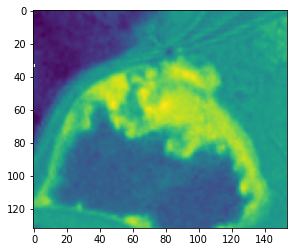

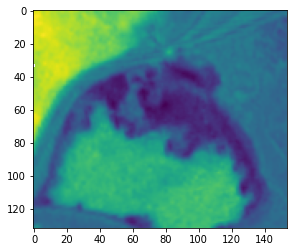

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [ ]:
for site in get_filelist():
    print("Generating data for: ", site[0])
    copy_files(site)
    write_ndvi("planetscope.tif")
    write_ndwi("planetscope.tif")
    clip_retile(site)
    gen_upload(site)